In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pymatgen.ext.matproj import MPRester
from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pandas
from ase import io
import os
from pymatgen.io.ase import AseAtomsAdaptor

In [2]:
def get_ref_data(element, reference_oxide_id):
    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            ref_fingerprint = unary_data[element]['fingerprints'][idx]
            ref_struct = unary_data[element]['structures'][idx]
            ref_ene = unary_data[element]['energies'][idx]
            ref_query = mpr.get_entry_by_material_id(reference_oxide_id, property_data=['formation_energy_per_atom'])
            ref_form_ene = ref_query.data['formation_energy_per_atom']
            print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene, ref_fingerprint

def get_ref_data_oqmd(element, reference_oxide_id):
    for idx, id_ in enumerate(oqmd_info['filename']):
        if reference_oxide_id in id_:
            ref_struct = oqmd_structs[reference_oxide_id]
            ref_form_ene = oqmd_info[' _oqmd_delta_e'][idx]
            #print(ref_form_ene)
            print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene#, ref_fingerprint

        
def structure_inspection(structure):
    """
    Need to know the coordination in a given oxide, the 2.5 Å cutoff could be tuned per element
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.)
            o_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    o_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations



def get_quadratic(lower_hull_data):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
        
    coeffs_ = np.polyfit(xs, ys, 2)
    x = np.linspace(0, 4, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    return coeffs_


def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox

            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull(low_ox_state_data, oxidation_state, ref_form_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
             if ox<=8 and oxidation_state==4:
                pairs.append((ox-oxidation_state,low_ox_state_data[ox][0]-ref_form_ene ))

        if len(pairs)==2:
            # need to add oxygen end member data
            pairs.append((oxidation_state, -ref_form_ene))
        #if 
        pairs = np.array(pairs)
        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            return None
    else:
        for ox in low_ox_state_data:
            pairs.append((oxidation_state-ox,low_ox_state_data[ox][0]-ref_form_ene ))
        if reference_element_=='Ni' or reference_element_=='Co' and oxidation_state==4:
            pairs.append((4, 0))
        pairs = np.array(pairs)

        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            return None
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull


def get_lower_hull_oqmd(low_ox_state_data, oxidation_state, ref_form_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
             if ox<=8 and oxidation_state==4:
                pairs.append((ox-oxidation_state,low_ox_state_data[ox]-ref_form_ene ))

        if len(pairs)==2:
            # need to add oxygen end member data
            pairs.append((oxidation_state, -ref_form_ene))
        pairs = np.array(pairs)
        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            return None
    else:
        for ox in low_ox_state_data:
            if reference_element_=='Sn' and ox==2 and oxidation_state==4:
                continue
            pairs.append((oxidation_state-ox,low_ox_state_data[ox]-ref_form_ene ))
        if reference_element_=='Ni' or reference_element_=='Co' and oxidation_state==4:
            pairs.append((4, 0))
        pairs = np.array(pairs)

        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            return None
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull


def get_ox2lowest(reference_element_, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    """
    ref_form_ene, ref_fingerprint_ = get_ref_data(reference_element_, ele2mp[reference_element_])
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords = structure_inspection(struct)
        if reference_element_ in ['Pd', 'Pt', 'Ir', 'Rh'] and ox_state>4 and list(set(o_o_coords))==[0] and list(set(m_coordinations))==[6]:
            print(m_coordinations, ox_state, o_o_coords, ref_form_ene)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>4
        else:
            bool2check = ox_state<4
        if bool2check and set(list(m_coordinations))=={6} and sum(o_o_coords)==0:
            struct_differences.append(struct_difference)
            query = mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
            formation_energy = query.data['formation_energy_per_atom']
            e_above_hull = query.data['e_above_hull']
            ox2data[ox_state].append(formation_energy)
            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, struct_difference)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, struct_difference)
    return ox2lowest


def get_ox2lowest_oqmd(reference_element_, ref_id, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    """
    ref_form_ene = get_ref_data_oqmd(reference_element_, ref_id)
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, oqmd_id in enumerate(oqmd_ids):
        #struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords = structure_inspection(oqmd_structs[oqmd_id])
        if reference_element_ in ['Pd', 'Pt', 'Ir', 'Rh'] and ox_state>4 and list(set(o_o_coords))==[0] and list(set(m_coordinations))==[6]:
            print(m_coordinations, ox_state, o_o_coords, oqmd_enes[oqmd_id], oqmd_id)

        if oxidising:
            bool2check = ox_state>4
        else:
            bool2check = ox_state<4
        
        
        if (bool2check):
            formation_energy = oqmd_enes[oqmd_id]
            ox2data[ox_state].append(formation_energy)
            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = formation_energy#, 0)#, struct_difference)

            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
                ox2lowest[ox_state] = formation_energy#, 0)#, struct_difference)
    return ox2lowest


def get_entry_by_spacegroup(oqmd_properties, spacegroup):
    """
    Returns the relevant ID which finds the matching oxide for a given stoichiometry,
    eg. P42/mnm for rutile
    """
    matching_rows = set()
    for row in oqmd_properties.values:
        if spacegroup in row:
            matching_rows.add(row[0])
    return matching_rows

Ti*
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
{5.5: -2.4411, 4.8: -2.4729, 6.0: -2.1094, 8.0: -1.4629, 5.0: -2.643}


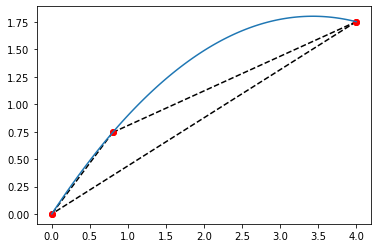

Reference oxide formation energy: -3.216 eV
{2.0: -2.7428, 1.0: -1.9864, 0.667: -1.5499, 0.4: 0.6886, 0.333: -0.933, 3.667: -3.2091, 3.714: -3.2068, 1.333: -2.2768, 3.0: -3.1219, 3.333: -3.1736, 2.5: -2.9429, 3.5: -3.189, 3.6: -3.1993}


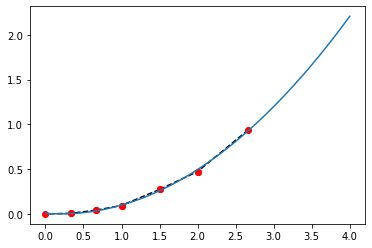

V*
Reference oxide formation energy: -2.501 eV
Reference oxide formation energy: -2.501 eV
{5.5: -1.987, 4.333: -2.3949, 6.0: -1.6536, 8.0: -1.1145, 5.0: -2.2634, 4.667: -2.3317, 5.333: -2.0123, 4.5: -2.3139}


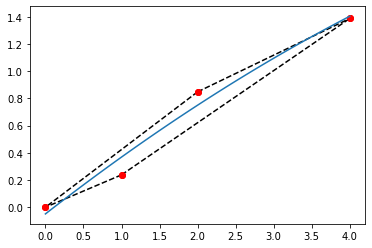

Reference oxide formation energy: -2.501 eV
{2.0: -2.2628, 1.0: -0.6273, 0.667: 0.2434, 0.4: 1.12, 0.25: 0.1691, 1.333: -1.2984, 0.375: -0.1625, 3.0: -2.6305, 0.857: -0.9766, 2.667: -2.3259, 3.333: -2.5769, 2.5: -2.2939, 3.5: -2.5462, 3.6: -2.5527}


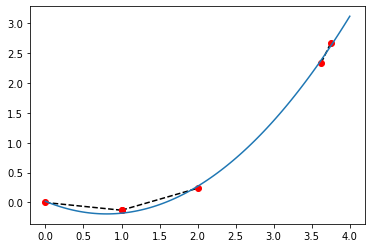

Cr*
Reference oxide formation energy: -2.114 eV
Reference oxide formation energy: -2.114 eV
{6.0: -1.4634, 8.0: -0.5688, 5.0: -1.6546, 5.333: -1.6176, 5.5: -1.4667, 5.25: -1.6813}


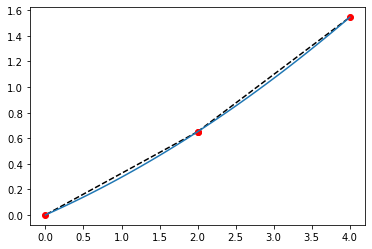

Reference oxide formation energy: -2.114 eV
{2.0: -2.1675, 1.0: -1.034, 3.0: -2.4859, 0.667: -0.4155, 2.5: -1.8372, 3.5: -2.1132, 0.4: 0.5883}


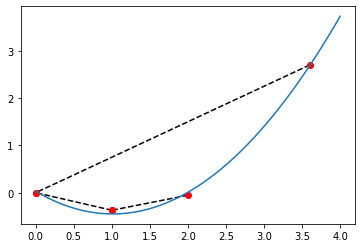

Mn*
Reference oxide formation energy: -1.712 eV
Reference oxide formation energy: -1.712 eV
{6.0: -0.9015, 8.0: -0.9432, 5.0: -1.1324, 7.0: -0.6478, 5.5: -0.9899, 4.8: -1.301}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


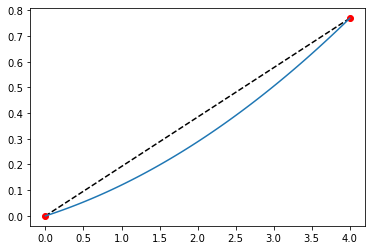

Reference oxide formation energy: -1.712 eV
{2.0: -2.0381, 1.0: -0.9536, 3.0: -2.0173, 0.667: -0.0043, 2.667: -2.0734, 2.5: -1.7179, 3.5: -1.7879, 0.4: 0.6398, 3.2: -1.9504, 2.286: -2.0159}


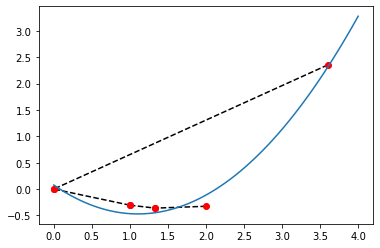

Fe*
Reference oxide formation energy: -1.302 eV
Reference oxide formation energy: -1.302 eV
{6.0: -0.824, 8.0: -0.6932, 5.0: -0.7296, 5.5: -0.9012}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


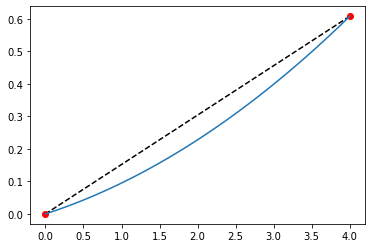

Reference oxide formation energy: -1.302 eV
{2.0: -1.543, 1.0: -0.4255, 3.0: -1.6498, 0.667: 0.2879, 2.667: -1.6607, 2.5: -1.2005, 0.4: 0.9898, 3.2: -1.5245}


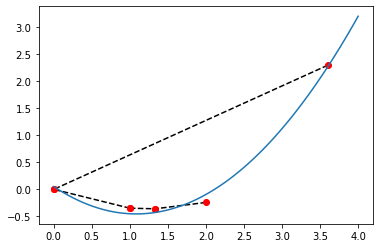

Co*
Reference oxide formation energy: -0.991 eV
Reference oxide formation energy: -0.991 eV
{6.0: -0.4155, 8.0: -0.6017, 5.0: -0.4472, 5.5: -0.3719}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


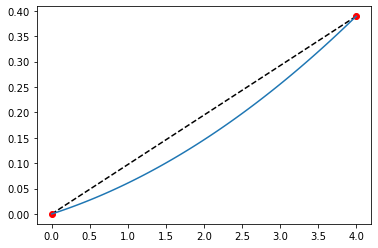

Reference oxide formation energy: -0.991 eV
{2.0: -1.2547, 1.0: -0.2714, 3.0: -1.1568, 0.667: 0.2029, 2.667: -1.3456, 2.5: -0.7309, 3.5: -0.9298, 2.333: -1.0542}


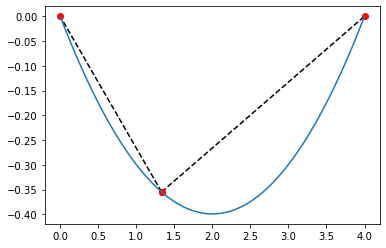

Ni*
Reference oxide formation energy: -0.482 eV
Reference oxide formation energy: -0.482 eV
{6.0: 0.057, 8.0: -0.5183, 5.0: 0.0778, 5.5: -0.5082}


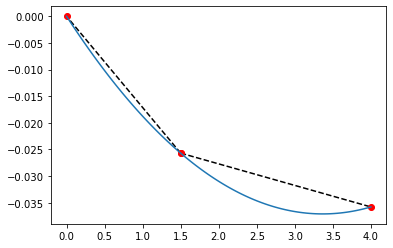

Reference oxide formation energy: -0.482 eV
{2.0: -1.2415, 1.0: -0.2555, 3.0: -0.9035, 0.667: 0.3525, 3.5: -0.5706, 0.4: 1.2419}


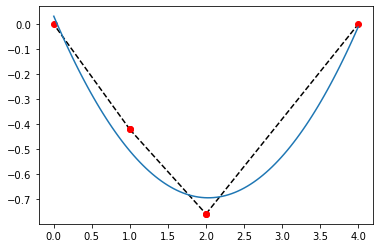

Cu*
No rutile struct for Cu
Nb*
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
{6.0: -1.4288, 8.0: -1.6557, 5.0: -2.8355}


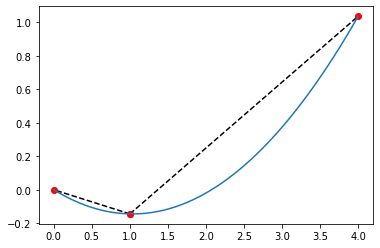

Reference oxide formation energy: -2.692 eV
{2.0: -2.155, 1.0: -1.2003, 3.0: -2.3931, 0.667: 0.1443, 2.5: -2.3197, 3.5: -2.3421}


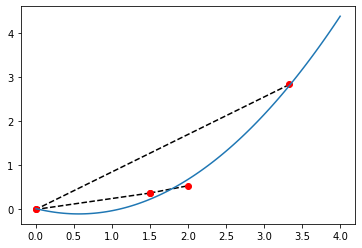

Mo*
Reference oxide formation energy: -2.099 eV
Reference oxide formation energy: -2.099 eV
{6.0: -2.163, 8.0: -1.2532, 5.0: -2.151, 5.5: -2.0254}


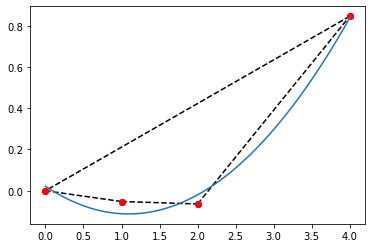

Reference oxide formation energy: -2.099 eV
{2.0: -0.9259, 1.0: -0.278, 3.0: -1.8977, 0.667: 0.3909, 2.5: -0.8127, 0.4: 1.0351}


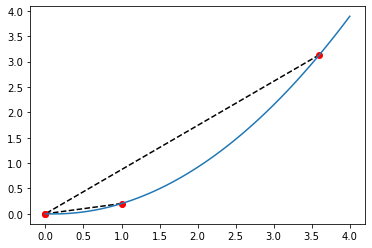

Li*
No rutile struct for Li
Be*
No rutile struct for Be
Na*
No rutile struct for Na
Mg*
Reference oxide formation energy: -1.151 eV
Reference oxide formation energy: -1.151 eV
{6.0: -1.234, 8.0: -1.1711, 10.0: -0.792}


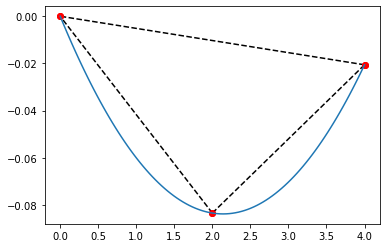

Reference oxide formation energy: -1.151 eV
{2.0: -2.9463, 0.013: -0.0034, 1.0: -1.7767, 3.0: -1.9021, 0.667: -1.1871, 2.5: -1.9876, 0.4: -0.7807}


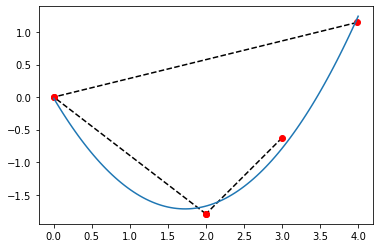

K*
No rutile struct for K
Ca*
No rutile struct for Ca
Rb*
Reference oxide formation energy: -1.010 eV
Reference oxide formation energy: -1.010 eV
{6.0: -0.8772}


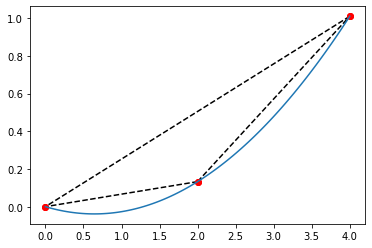

Reference oxide formation energy: -1.010 eV
{2.0: -1.2022, 1.0: -1.0511, 0.667: -0.8348, 0.4: 0.3178, 0.333: -0.4768, 1.333: -1.0053, 0.444: -0.6213, 3.0: -1.1373, 2.5: -0.1551}


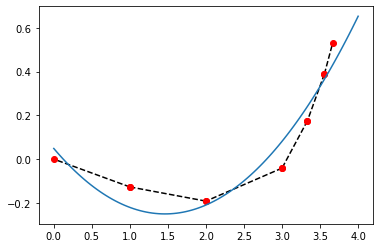

Sr*
Reference oxide formation energy: -2.109 eV
Reference oxide formation energy: -2.109 eV
{6.0: -0.8879}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


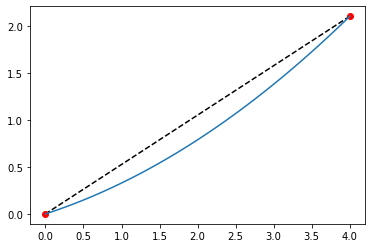

Reference oxide formation energy: -2.109 eV
{2.0: -2.9456, 1.0: -1.5692, 0.667: -1.0669, 1.333: -2.1255, 3.0: -2.0576, 2.5: -2.1516}


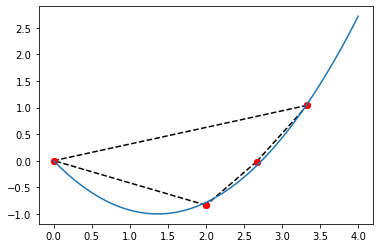

Cs*
No rutile struct for Cs
Ba*
No rutile struct for Ba
Sc*
Reference oxide formation energy: -2.835 eV
Reference oxide formation energy: -2.835 eV
{5.5: -2.323, 6.0: -2.1293, 8.0: -1.6791, 5.0: -1.9908}


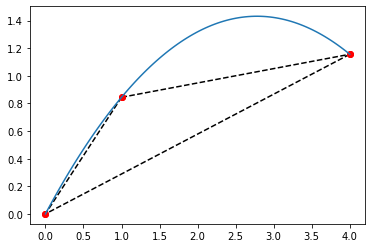

Reference oxide formation energy: -2.835 eV
{2.0: -3.1065, 1.0: -1.1496, 0.667: -0.9481, 0.4: 0.7488, 1.333: -2.473, 3.0: -3.8074, 2.5: -3.0552}


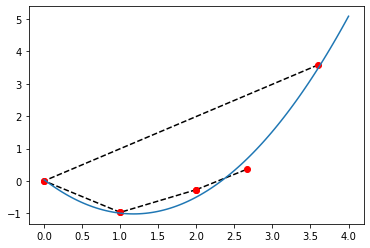

Ti*
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
{5.5: -2.4411, 4.8: -2.4729, 6.0: -2.1094, 8.0: -1.4629, 5.0: -2.643}


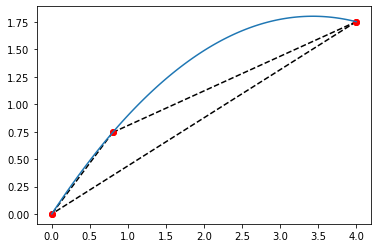

Reference oxide formation energy: -3.216 eV
{2.0: -2.7428, 1.0: -1.9864, 0.667: -1.5499, 0.4: 0.6886, 0.333: -0.933, 3.667: -3.2091, 3.714: -3.2068, 1.333: -2.2768, 3.0: -3.1219, 3.333: -3.1736, 2.5: -2.9429, 3.5: -3.189, 3.6: -3.1993}


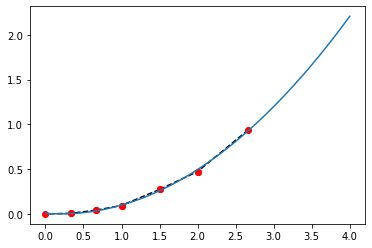

V*
Reference oxide formation energy: -2.501 eV
Reference oxide formation energy: -2.501 eV
{5.5: -1.987, 4.333: -2.3949, 6.0: -1.6536, 8.0: -1.1145, 5.0: -2.2634, 4.667: -2.3317, 5.333: -2.0123, 4.5: -2.3139}


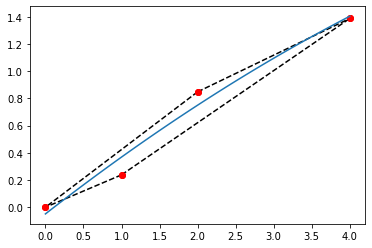

Reference oxide formation energy: -2.501 eV
{2.0: -2.2628, 1.0: -0.6273, 0.667: 0.2434, 0.4: 1.12, 0.25: 0.1691, 1.333: -1.2984, 0.375: -0.1625, 3.0: -2.6305, 0.857: -0.9766, 2.667: -2.3259, 3.333: -2.5769, 2.5: -2.2939, 3.5: -2.5462, 3.6: -2.5527}


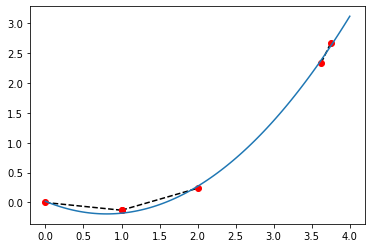

Cr*
Reference oxide formation energy: -2.114 eV
Reference oxide formation energy: -2.114 eV
{6.0: -1.4634, 8.0: -0.5688, 5.0: -1.6546, 5.333: -1.6176, 5.5: -1.4667, 5.25: -1.6813}


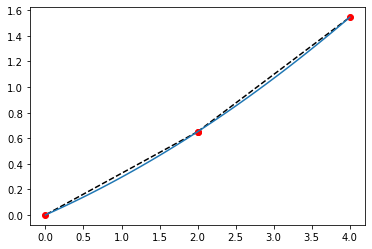

Reference oxide formation energy: -2.114 eV
{2.0: -2.1675, 1.0: -1.034, 3.0: -2.4859, 0.667: -0.4155, 2.5: -1.8372, 3.5: -2.1132, 0.4: 0.5883}


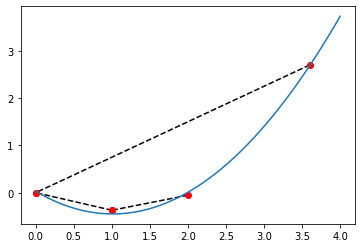

Mn*
Reference oxide formation energy: -1.712 eV
Reference oxide formation energy: -1.712 eV
{6.0: -0.9015, 8.0: -0.9432, 5.0: -1.1324, 7.0: -0.6478, 5.5: -0.9899, 4.8: -1.301}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


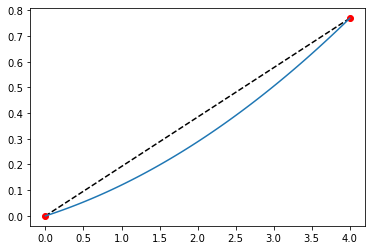

Reference oxide formation energy: -1.712 eV
{2.0: -2.0381, 1.0: -0.9536, 3.0: -2.0173, 0.667: -0.0043, 2.667: -2.0734, 2.5: -1.7179, 3.5: -1.7879, 0.4: 0.6398, 3.2: -1.9504, 2.286: -2.0159}


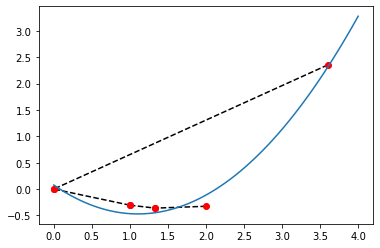

Fe*
Reference oxide formation energy: -1.302 eV
Reference oxide formation energy: -1.302 eV
{6.0: -0.824, 8.0: -0.6932, 5.0: -0.7296, 5.5: -0.9012}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


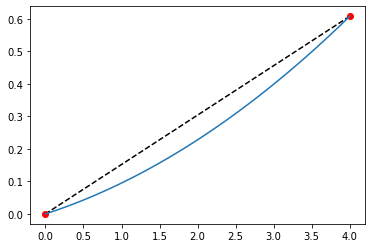

Reference oxide formation energy: -1.302 eV
{2.0: -1.543, 1.0: -0.4255, 3.0: -1.6498, 0.667: 0.2879, 2.667: -1.6607, 2.5: -1.2005, 0.4: 0.9898, 3.2: -1.5245}


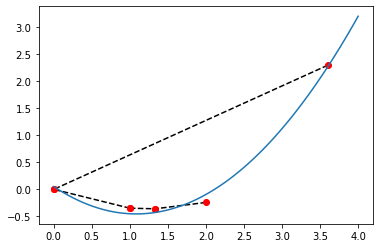

Co*
Reference oxide formation energy: -0.991 eV
Reference oxide formation energy: -0.991 eV
{6.0: -0.4155, 8.0: -0.6017, 5.0: -0.4472, 5.5: -0.3719}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


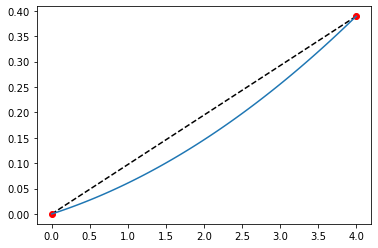

Reference oxide formation energy: -0.991 eV
{2.0: -1.2547, 1.0: -0.2714, 3.0: -1.1568, 0.667: 0.2029, 2.667: -1.3456, 2.5: -0.7309, 3.5: -0.9298, 2.333: -1.0542}


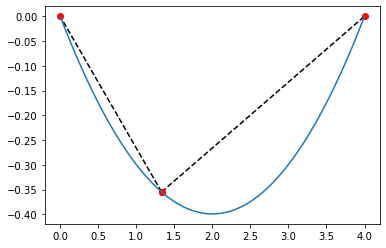

Ni*
Reference oxide formation energy: -0.482 eV
Reference oxide formation energy: -0.482 eV
{6.0: 0.057, 8.0: -0.5183, 5.0: 0.0778, 5.5: -0.5082}


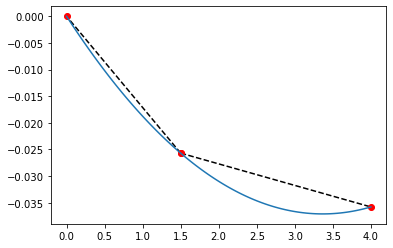

Reference oxide formation energy: -0.482 eV
{2.0: -1.2415, 1.0: -0.2555, 3.0: -0.9035, 0.667: 0.3525, 3.5: -0.5706, 0.4: 1.2419}


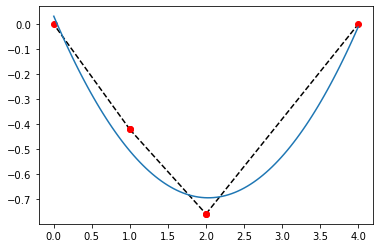

Cu*
No rutile struct for Cu
Zn*
Reference oxide formation energy: -0.502 eV
Reference oxide formation energy: -0.502 eV
{5.5: -0.7157, 6.0: -0.6597, 8.0: -0.5494, 5.0: -0.683}


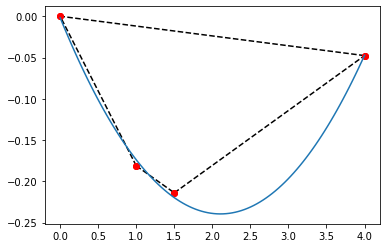

Reference oxide formation energy: -0.502 eV
{2.0: -1.6489, 1.0: -0.3586, 0.667: -0.1729, 0.4: 0.2354, 1.333: -0.7838, 3.0: -0.9817, 2.5: -0.8636}


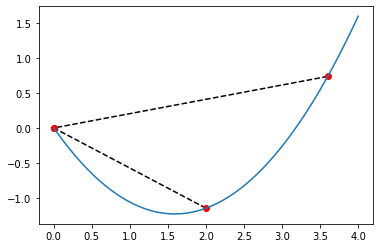

Ga*
No rutile struct for Ga
Ge*
Reference oxide formation energy: -1.889 eV
Reference oxide formation energy: -1.889 eV
{6.0: -1.1684, 8.0: -0.3803, 5.0: -1.425, 7.0: -0.8604, 5.5: -1.2439, 4.8: -1.2816, 4.286: -1.6384}


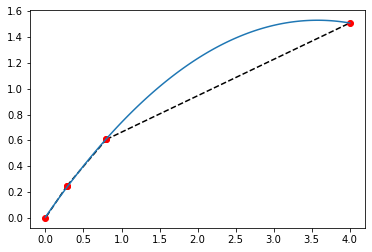

Reference oxide formation energy: -1.889 eV
{2.0: -1.3452, 1.0: -0.4151, 3.0: -1.6655, 0.667: 0.1339, 2.5: -1.07, 0.4: 0.4825}


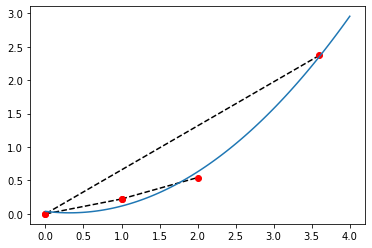

As*
No rutile struct for As
Se*
Reference oxide formation energy: -0.593 eV
Reference oxide formation energy: -0.593 eV
{6.0: -0.6302, 5.0: -0.8038}


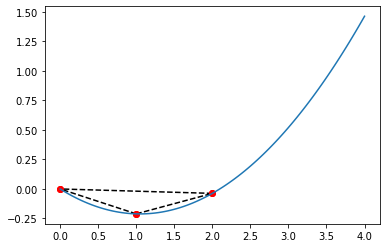

Reference oxide formation energy: -0.593 eV
{2.0: 0.294, 1.0: 0.3261, 0.667: 0.3996, 0.4: 0.8266, 1.333: 0.179, 2.5: -0.5145}
returning linear eq
Br*
No rutile struct for Br
Y*
Reference oxide formation energy: -2.827 eV
Reference oxide formation energy: -2.827 eV
{5.5: -2.4276, 6.0: -2.0298, 8.0: -1.8373, 5.0: -2.3241}


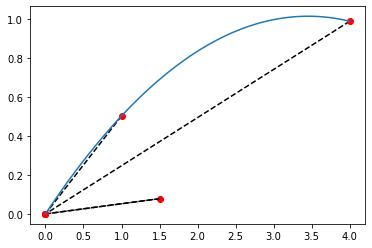

Reference oxide formation energy: -2.827 eV
{2.0: -2.9776, 1.0: 0.6006, 0.667: -0.8355, 1.333: -2.3657, 3.0: -3.8082, 2.5: -3.0898, 3.5: -3.2498}


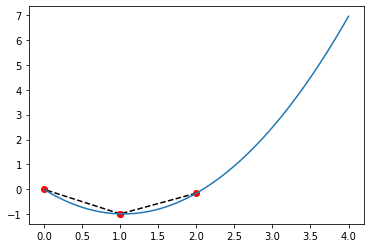

Zr*
Reference oxide formation energy: -3.583 eV
Reference oxide formation energy: -3.583 eV
{5.5: -2.685, 6.0: -2.4871, 8.0: -2.0167, 5.0: -2.7366, 7.0: -1.9482}


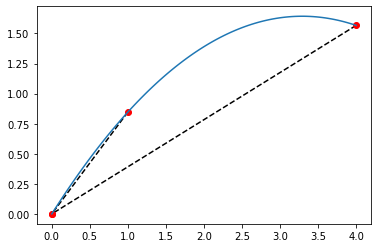

Reference oxide formation energy: -3.583 eV
{2.0: -2.5231, 1.0: -1.6811, 0.667: -1.4788, 1.333: -2.2276, 3.0: -3.1052, 2.5: -2.2893, 3.5: -3.3777}


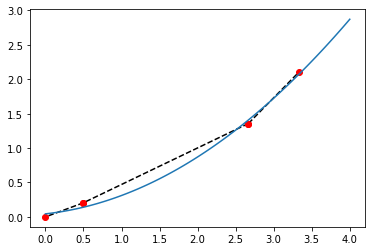

Nb*
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
{6.0: -1.4288, 8.0: -1.6557, 5.0: -2.8355}


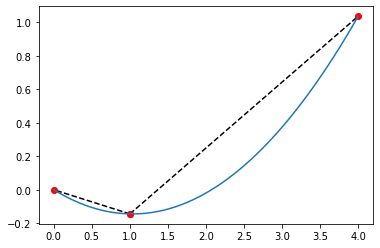

Reference oxide formation energy: -2.692 eV
{2.0: -2.155, 1.0: -1.2003, 3.0: -2.3931, 0.667: 0.1443, 2.5: -2.3197, 3.5: -2.3421}


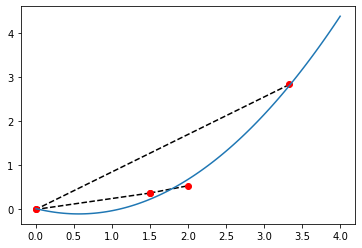

Mo*
Reference oxide formation energy: -2.099 eV
Reference oxide formation energy: -2.099 eV
{6.0: -2.163, 8.0: -1.2532, 5.0: -2.151, 5.5: -2.0254}


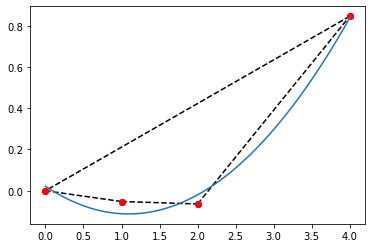

Reference oxide formation energy: -2.099 eV
{2.0: -0.9259, 1.0: -0.278, 3.0: -1.8977, 0.667: 0.3909, 2.5: -0.8127, 0.4: 1.0351}


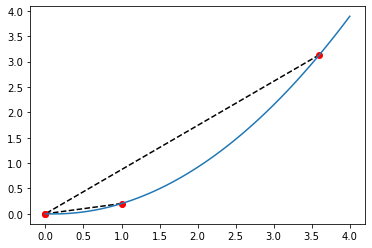

Tc*
Reference oxide formation energy: -1.651 eV
Reference oxide formation energy: -1.651 eV
{5.5: -1.4905, 6.0: -1.5168, 8.0: -1.1574, 5.0: -1.4926, 7.0: -1.5499}


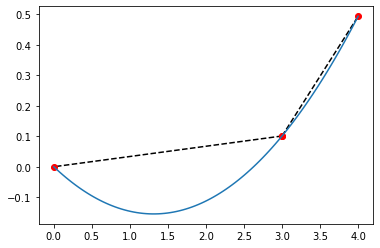

Reference oxide formation energy: -1.651 eV
{2.0: -0.4771, 1.0: 1.2185, 0.667: 0.0581, 1.333: -0.158, 3.0: -0.6338, 2.5: -0.4316}


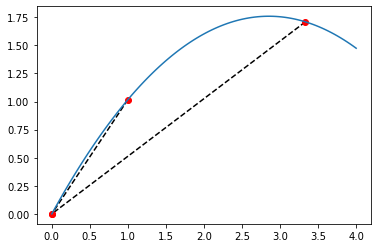

Ru*
Reference oxide formation energy: -1.266 eV
Reference oxide formation energy: -1.266 eV
{5.5: -0.9531, 6.0: -0.9614, 8.0: -0.8668, 5.0: -1.0829}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


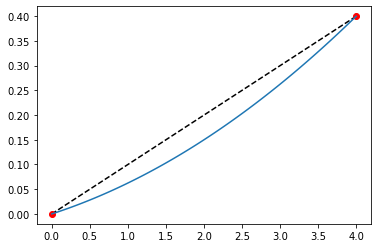

Reference oxide formation energy: -1.266 eV
{2.0: -0.2537, 1.0: 0.7269, 0.667: 0.4171, 0.4: 1.1378, 3.429: -0.8977, 1.333: 0.0242, 3.0: -0.9507, 2.5: -0.0616, 3.5: -0.988}


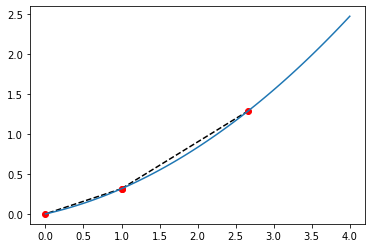

Rh*
Reference oxide formation energy: -1.038 eV
Reference oxide formation energy: -1.038 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085

/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


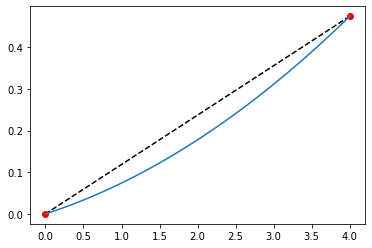

Reference oxide formation energy: -1.038 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062 ID-318726
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.5166 ID-690792
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4091 ID-694990
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.4832 ID-694989
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.511 ID-825006
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4282 ID-825032
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.4343 ID-825033
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.085 ID-1343165
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.3062

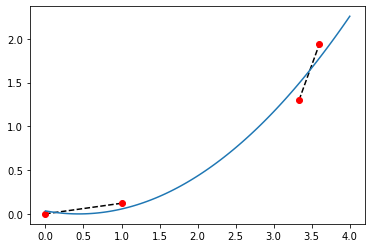

Pd*
Reference oxide formation energy: -0.542 eV
Reference oxide formation energy: -0.542 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
{5.5: -0.3215, 6.0: -0.3234, 8.0: -0.3845, 5.0: -0.3114}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


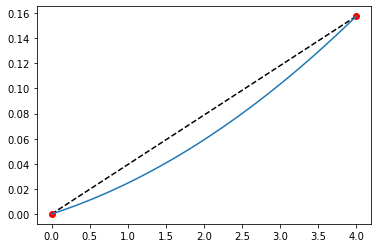

Reference oxide formation energy: -0.542 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.6086 ID-324857
{2.0: -0.6494, 1.0: -0.2938, 0.667: 0.2232, 0.4: 0.6866, 1.333: -0.3676, 3.0: -0.6444, 2.5: -0.0509}


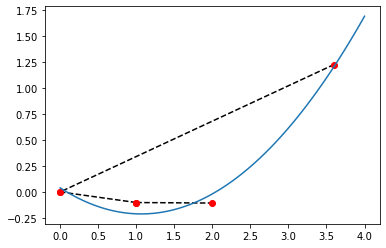

Ag*
No rutile struct for Ag
Cd*
No rutile struct for Cd
In*
No rutile struct for In
Sn*
Reference oxide formation energy: -1.954 eV
Reference oxide formation energy: -1.954 eV
{5.5: -1.3104, 6.0: -1.1579, 5.0: -1.2146, 12.0: 0.3258}
returning linear eq


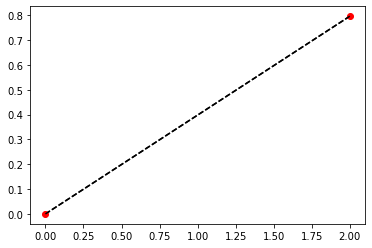

Reference oxide formation energy: -1.954 eV
{2.0: -1.5371, 1.0: 0.0676, 0.667: -0.0749, 0.4: 0.3107, 1.333: -0.8108, 3.0: -1.7493, 2.667: -1.6146, 2.5: -1.3118, 2.4: -1.3594, 3.5: -1.6876}


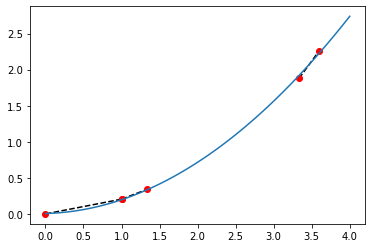

Sb*
Reference oxide formation energy: -1.448 eV
Reference oxide formation energy: -1.448 eV
{6.0: -0.2105, 5.0: -1.5501}


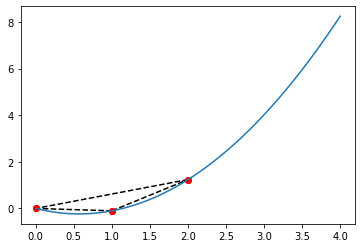

Reference oxide formation energy: -1.448 eV
{2.0: -0.6918, 1.0: 0.0946, 0.667: -0.0697, 0.4: 0.5233, 1.333: -0.7648, 3.0: -1.5796, 2.5: -0.9003, 3.5: -1.3607}


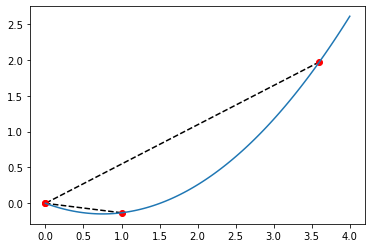

Te*
Reference oxide formation energy: -1.089 eV
Reference oxide formation energy: -1.089 eV
{6.0: -1.1054, 5.0: -1.2077, 4.667: -1.1377, 4.5: -1.2477}


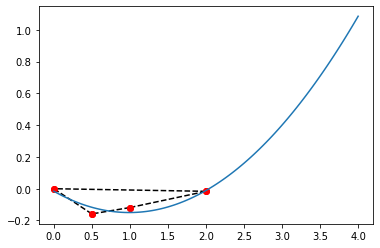

Reference oxide formation energy: -1.089 eV
{2.0: -0.1698, 1.0: -0.3108, 0.667: -0.0866, 0.5: -0.0783, 0.4: 0.6807, 1.333: -0.4119, 3.0: -0.4267, 1.143: -0.3749, 2.5: -0.6187}


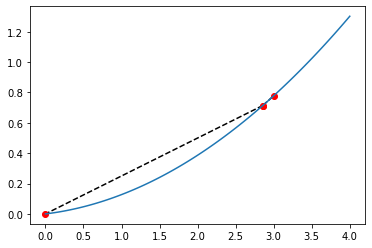

I*
No rutile struct for I
Hf*
Reference oxide formation energy: -3.814 eV
Reference oxide formation energy: -3.814 eV
{6.0: -2.6899, 8.0: -2.1238, 5.0: -3.0102, 5.5: -2.7921}


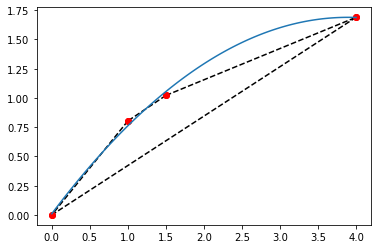

Reference oxide formation energy: -3.814 eV
{2.0: -2.4847, 1.0: -1.8267, 3.0: -3.1184, 0.667: -1.4756, 2.5: -2.3265, 3.5: -3.5357, 0.4: 1.0244}


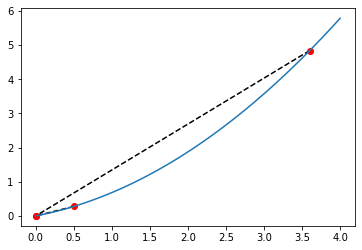

Ta*
Reference oxide formation energy: -2.856 eV
Reference oxide formation energy: -2.856 eV
{6.0: -1.6064, 8.0: -1.865, 5.0: -3.1436}


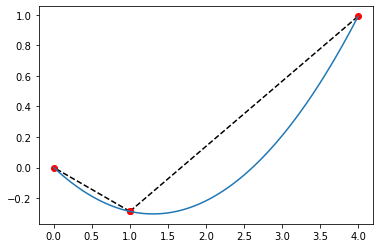

Reference oxide formation energy: -2.856 eV
{2.0: -1.5884, 1.0: 0.3069, 0.667: 0.2991, 0.5: -0.6635, 0.4: 1.1205, 1.333: -1.2273, 3.0: -2.3265, 2.5: -1.5443, 3.5: -2.3865}


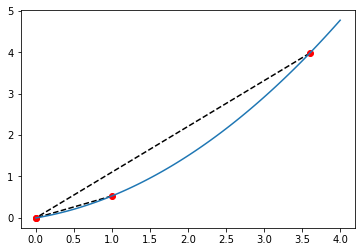

W*
Reference oxide formation energy: -2.120 eV
Reference oxide formation energy: -2.120 eV
{6.0: -2.4458, 8.0: -1.5927, 5.333: -2.3414}


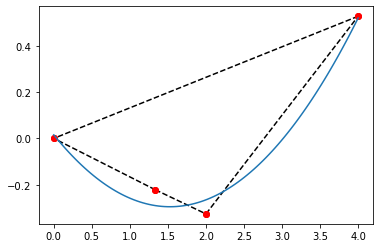

Reference oxide formation energy: -2.120 eV
{2.0: -0.5625, 1.0: 1.5917, 0.667: 0.6185, 0.4: 1.2178, 2.182: -1.1245, 1.333: -0.2992, 3.0: -1.7421, 2.5: -0.854}


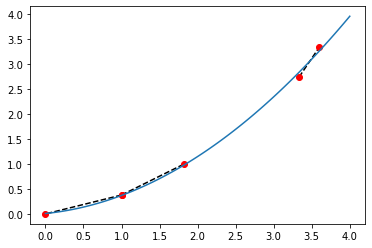

Re*
Reference oxide formation energy: -1.587 eV
Reference oxide formation energy: -1.587 eV
{6.0: -1.9047, 8.0: -1.3721, 5.0: -1.7584, 7.0: -1.7567}


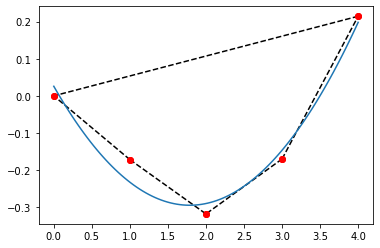

Reference oxide formation energy: -1.587 eV
{2.0: -0.0688, 1.0: 1.1941, 0.667: 0.2812, 0.4: 1.0151, 1.333: -0.0253, 3.0: -0.0802, 2.5: -0.3878, 3.5: -1.0145}


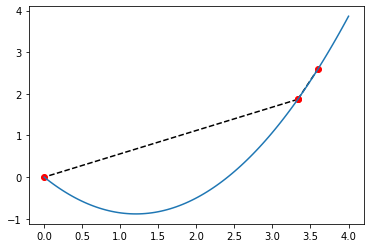

Os*
Reference oxide formation energy: -1.161 eV
Reference oxide formation energy: -1.161 eV
{5.5: -1.0592, 6.0: -1.2007, 8.0: -1.2655, 5.0: -1.1885}


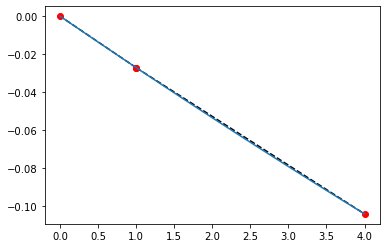

Reference oxide formation energy: -1.161 eV
{2.0: 0.3296, 1.0: 1.8164, 0.667: 0.7234, 0.4: 1.2956, 1.333: 0.3626, 3.0: -0.5167, 2.5: 0.1231, 3.5: -0.7609}


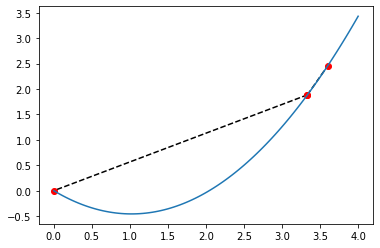

Ir*
Reference oxide formation energy: -1.064 eV
Reference oxide formation energy: -1.064 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7798 ID-690788
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7156 ID-694982
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7947 ID-694981
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7769 ID-825007
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6605 ID-825035
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6593 ID-825034
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8429 ID-1376066
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8407 ID-1708421
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.6528 ID-1710517
[6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7565 ID-1710518
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6515 ID-1758933
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7215 ID-1758934
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.5091 ID-1343155
[6, 6] 5.0 [0, 0, 0, 0, 0] -0.7744 ID-1443330
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288

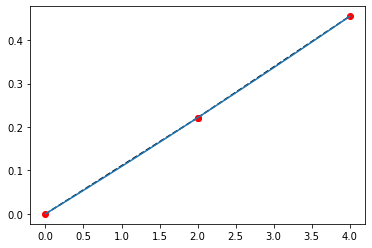

Reference oxide formation energy: -1.064 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7798 ID-690788
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7156 ID-694982
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7947 ID-694981
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7769 ID-825007
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6605 ID-825035
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6593 ID-825034
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8429 ID-1376066
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.8407 ID-1708421
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.6528 ID-1710517
[6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7565 ID-1710518
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.6515 ID-1758933
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.7215 ID-1758934
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] -0.5091 ID-1343155
[6, 6] 5.0 [0, 0, 0, 0, 0] -0.7744 ID-1443330
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.1735 ID-325288
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.7798 ID-690788

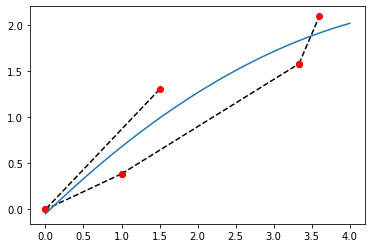

Pt*
Reference oxide formation energy: -0.700 eV
Reference oxide formation energy: -0.700 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 

/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


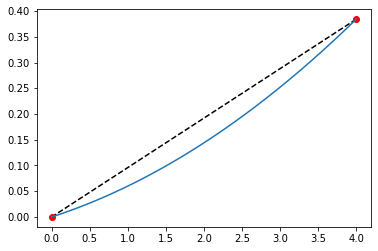

Reference oxide formation energy: -0.700 eV
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] 0.4074 ID-318480
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.3287 ID-690791
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2299 ID-694988
[6, 6] 6.0 [0, 0, 0, 0, 0, 0] -0.2536 ID-694987
[6, 6, 6, 6] 6.0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] -0.3231 ID-824999
[6, 6] 8.0 [0, 0, 0, 0, 0, 0, 0, 0] 0.0976 ID-1343163
[6, 6

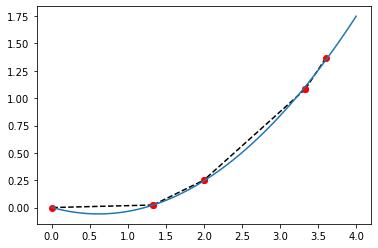

Au*
No rutile struct for Au
Hg*
No rutile struct for Hg
Tl*
Reference oxide formation energy: -0.392 eV
Reference oxide formation energy: -0.392 eV
{6.0: 0.411}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


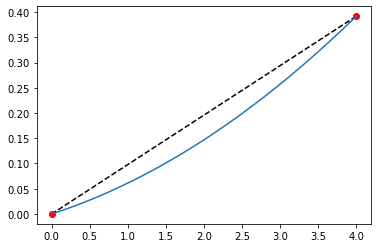

Reference oxide formation energy: -0.392 eV
{2.0: -0.7592, 1.0: -0.7247, 0.667: -0.3909, 0.4: 0.3232, 1.333: -0.5363, 3.0: -0.9373, 1.5: -0.8107, 2.5: -0.7557, 3.5: -0.6217}


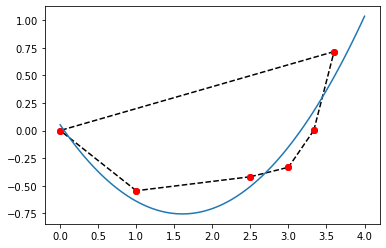

Pb*
Reference oxide formation energy: -1.118 eV
Reference oxide formation energy: -1.118 eV
{5.5: -0.6989, 6.0: -0.7087, 5.0: -0.4382}
returning linear eq


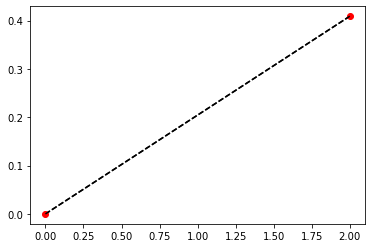

Reference oxide formation energy: -1.118 eV
{2.0: -1.3214, 1.0: -0.5457, 0.667: 0.0489, 0.4: 0.4224, 3.0: -1.2225, 2.667: -1.285, 2.5: -1.0225}


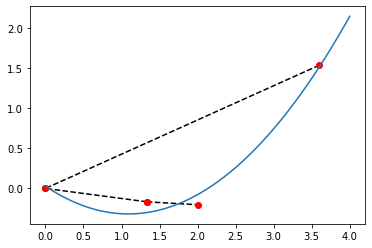

Bi*
No rutile struct for Bi
La*
No rutile struct for La
Ce*
Reference oxide formation energy: -2.597 eV
Reference oxide formation energy: -2.597 eV
{6.0: -1.7366}


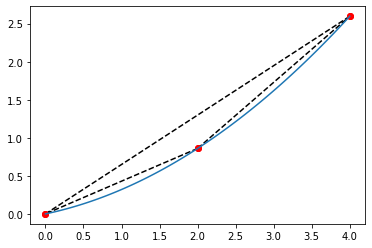

Reference oxide formation energy: -2.597 eV
{2.0: -2.8736, 3.636: -3.0415, 1.0: -1.835, 3.0: -3.5204, 0.667: -0.786, 2.5: -2.5797, 0.4: 0.702, 3.429: -3.1866}


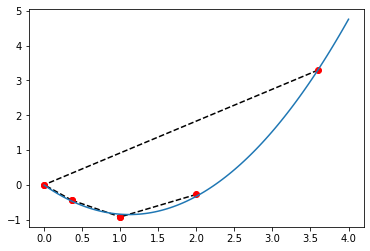

Nd*
No rutile struct for Nd
Pr*
Reference oxide formation energy: -2.634 eV
Reference oxide formation energy: -2.634 eV
{6.0: -1.754}


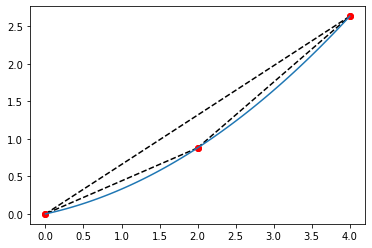

Reference oxide formation energy: -2.634 eV
{2.0: -2.9142, 1.0: -1.2243, 0.667: -0.7954, 3.429: -3.2343, 3.556: -3.1667, 1.333: -2.2454, 3.0: -3.5761, 2.5: -2.6175}


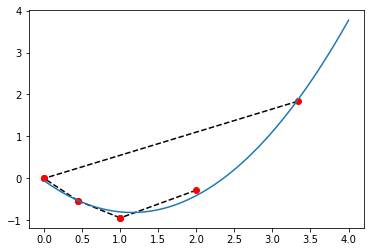

Sm*
Reference oxide formation energy: -2.736 eV
Reference oxide formation energy: -2.736 eV
{6.0: -1.7786}


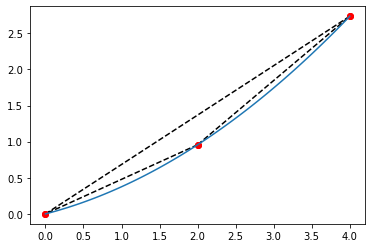

Reference oxide formation energy: -2.736 eV
{2.0: -3.0267, 1.0: -1.0232, 0.667: -0.7942, 1.333: -2.3118, 1.313: -2.2583, 3.0: -3.701, 2.5: -2.971}


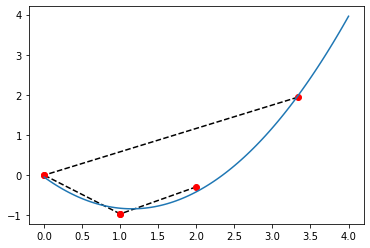

Eu*
No rutile struct for Eu
Gd*
No rutile struct for Gd
Tb*
Reference oxide formation energy: -2.617 eV
Reference oxide formation energy: -2.617 eV
{6.0: -1.6312}


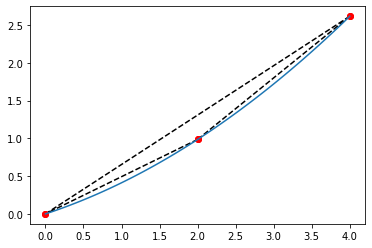

Reference oxide formation energy: -2.617 eV
{2.0: -2.6818, 1.0: -0.6328, 0.667: -0.3783, 0.4: 1.3403, 3.429: -3.1952, 1.333: -1.9721, 3.636: -3.0306, 3.0: -3.5603, 2.5: -2.8295}


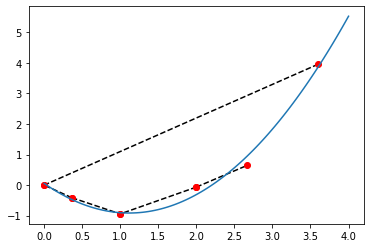

Dy*
No rutile struct for Dy
Ho*
No rutile struct for Ho
Er*
No rutile struct for Er
Tm*
Reference oxide formation energy: -2.933 eV
Reference oxide formation energy: -2.933 eV
{6.0: -1.7941}


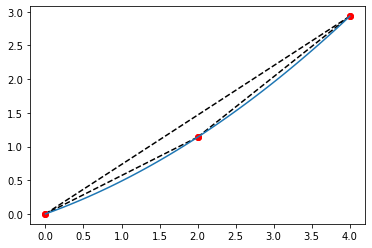

Reference oxide formation energy: -2.933 eV
{2.0: -3.1954, 1.0: -1.134, 0.667: -0.9192, 0.4: 0.7844, 1.333: -2.3965, 3.0: -3.9318, 2.5: -3.1559}


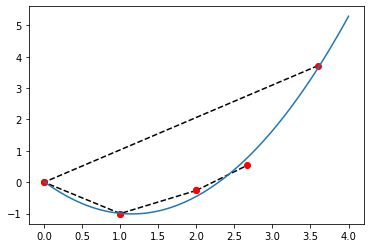

Yb*
Reference oxide formation energy: -2.404 eV
Reference oxide formation energy: -2.404 eV
{6.0: -1.1668}


/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_66897/3368719176.py:69: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


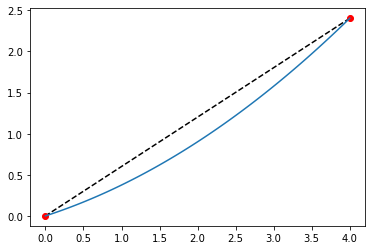

Reference oxide formation energy: -2.404 eV
{2.0: -3.5084, 1.0: -1.7903, 0.667: -1.3099, 0.4: 0.4507, 1.333: -2.546, 3.0: -2.5607, 2.5: -2.5627}


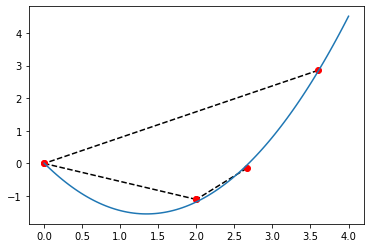

Lu*
No rutile struct for Lu


In [8]:
elements2consider = [ "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Nb", "Mo",
           "Li", "Be", "Na", "Mg", "K", "Ca", "Rb", "Sr", "Cs", "Ba",
            "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn",
            "Ga", "Ge", "As", "Se", "Br",
            "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd",
            "In", "Sn", "Sb", "Te", "I",
            "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", 
            "Tl", "Pb", "Bi",
           "La", "Ce", "Nd", "Pr", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]

ref_oxidation_state = 4
quadratic_equations_ox = defaultdict()
quadratic_equations_red = defaultdict()
for ele in elements2consider:
    oqmd_info = pandas.read_csv("../data_gather/oqmd_data/target_props/target_properties_{}o2.csv".format(ele))
    print("{}*".format(ele))
    oqmd_enes = defaultdict()
    #print(oqmd_info)
    spg_match_data = get_entry_by_spacegroup(oqmd_info, "P42/mnm")

    matching_ids = []
    for match in spg_match_data:
        matching_ids.append(match.split("En")[1].split(".")[0])

    oqmd_ids = []
    for name, energy in zip(oqmd_info['filename'], oqmd_info[' _oqmd_delta_e']):
        #print(energy, name)
        oqmd_id = name.split("En")[1].split('.')[0]
        oqmd_enes[oqmd_id] = energy
        oqmd_ids.append(oqmd_id)

    poscars = os.popen("ls ../data_gather/oqmd_data/input_poscars/input_poscars_{}o2".format(ele)).readlines()
    poscars = [x.strip("\n") for x in poscars]
    oqmd_structs = defaultdict()
    for poscar in poscars:
        struct = io.read("../data_gather/oqmd_data/input_poscars/input_poscars_{}o2/{}".format(ele, poscar))
        pymat_struct = AseAtomsAdaptor.get_structure(struct)
        oqmd_structs[poscar.split("En")[1].split('.')[0]] = pymat_struct
        
    # need to find the reference id
    reference_found = False
    for match in matching_ids:
        cords, oxi_state, o_o_coords = structure_inspection(oqmd_structs[match])
        #print(data)
        if oxi_state==ref_oxidation_state:
            reference_id = match
            reference_found = True
    if not reference_found:
        print("No rutile struct for {}".format(ele))
        continue

    ref_ene = get_ref_data_oqmd(ele, reference_id)

    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=True)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=True)
    
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        # add end member to allow for a fitted quadratic equation
        # just return the linear equation which passes through the observed point
        non_ref = sorted(other_oxes)[1]
        coeffs = [0, hull_ox2energy[non_ref]/non_ref, 0]
        print('returning linear eq')
        plt.plot([0, non_ref], [0, hull_ox2energy[non_ref]], 'k--')
        quadratic_equations_ox[ele] = coeffs
    elif hull_ox2energy is not None:
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_ox[ele] = coeffs
    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not much info ...")
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
    plt.show()
    
    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=False)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=False)
    
    if hull_ox2energy is None:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
        
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        # just return the linear equation which passes through the observed point
        non_ref = sorted(other_oxes)[1]
        coeffs = [0, hull_ox2energy[non_ref]/non_ref, 0]
        print('returning linear eq')
        plt.plot([0, non_ref], [0, hull_ox2energy[non_ref]], 'k--')
        quadratic_equations_ox[ele] = coeffs

    elif len(other_oxes)==2 and hull_ox2energy is not None:
        # none of the points are on or below hull, so take linear equation to lowest point.
            
        print("Unsure what to do for: {}".format(ele))
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
    elif hull_ox2energy is not None:
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = coeffs

    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not enough info ...")
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]

    
    

In [9]:
pickle.dump(quadratic_equations_ox, open("oqmd_quadratic_equations_ox.p", "wb"))
pickle.dump(quadratic_equations_red, open("oqmd_quadratic_equations_red.p", "wb"))
